In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c girlsgoit-competition-2020

!unzip train.csv.zip 
!unzip test.csv.zip

!rm *.zip

  0% 0.00/3.49M [00:00<?, ?B/s]
100% 3.49M/3.49M [00:00<00:00, 57.2MB/s]
  0% 0.00/416k [00:00<?, ?B/s]
100% 416k/416k [00:00<00:00, 129MB/s]
  0% 0.00/7.98M [00:00<?, ?B/s]
100% 7.98M/7.98M [00:00<00:00, 66.2MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torchvision import transforms

%matplotlib inline
sns.set_style("whitegrid")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda')

In [ ]:
data = pd.read_csv('train.csv')
x_cols = ['acousticness', 	'artists', 	'danceability', 	'duration_ms', 	'energy', 	'explicit', 	'instrumentalness', 	'key', 	'liveness', 	'loudness', 	'mode', 	'name', 	'release_date', 	'speechiness', 	'tempo', 	'valence', 	'year']
target = data['popularity']

data.head()

,ID,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,release_date,speechiness,tempo,valence,year,popularity
0,53876,0.4470,['Sister Nancy'],0.759,199480,0.5300,0,0.01130,8,0.0794,-8.023,1,Ain't No Stopping Nancy,2002-03-15,0.4180,78.354,0.596,2002,4
1,92111,0.8280,['Jimmy Smith'],0.714,483093,0.3670,0,0.39900,5,0.1120,-12.855,1,Back At The Chicken Shack,1963-02-12,0.0328,107.328,0.633,1963,4
2,28869,0.0244,['U2'],0.380,347757,0.7380,0,0.02290,8,0.4320,-10.737,1,Bullet The Blue Sky - Live,1987-03-03,0.0539,77.464,0.369,1987,4
3,24797,0.8880,"['George Frideric Handel', 'The Liverpool Phil...",0.116,300267,0.1840,0,0.92200,4,0.1550,-16.827,0,"Messiah, HWV 56, Pt. 1: Symphony",1946,0.0397,74.188,0.106,1946,0
4,71551,0.9930,['Artus Moser'],0.367,160227,0.0356,0,0.00131,5,0.1140,-22.607,0,Lord Randall,1955-01-01,0.0486,94.628,0.443,1955,0


In [ ]:
data_X = pd.DataFrame()

data_X['year_band']=pd.cut(data['year'],
                               bins=[1920,1950,1970,1985,2000,2021],
                               labels = [0,1,2,3,4],include_lowest=True)

data_X['duration_band']=pd.cut(data['duration_ms'],
                               bins=[0,60000,180000,300000,540000,5500000],
                               labels = [0,1,2,3,4],include_lowest=True)

loudness = -1*data['loudness']
data_X['loudness_band']=pd.cut(loudness,
                               bins=[-5,0,7,10,15,20,30,60],
                               labels = [0,1,2,3,4,5,6],include_lowest=True)

data_X['tempo_band']=pd.cut(data['tempo'],
                               bins=[0,30,50,80,100,120,150,180,200,250],
                               labels = [0,1,2,3,4,5,6,7,8],include_lowest=True)



In [ ]:
cols_to_itter = ['acousticness', 'danceability', 	'energy', 	'explicit', 	'instrumentalness', 	'key', 	'liveness', 	'mode',	'speechiness', 	'valence']

for col in cols_to_itter:
  data_X[col] = data[col]

In [ ]:
data_X.shape

(118936, 14)

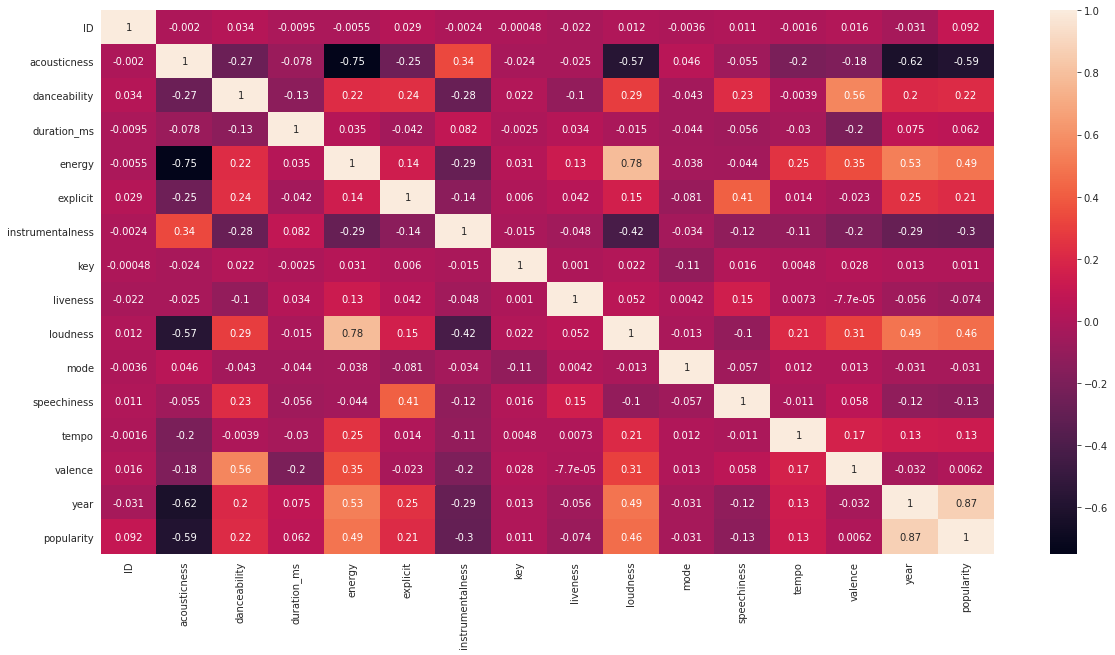

In [ ]:
corr = data.corr()
# print(corr)

import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
ax = sn.heatmap(corr, annot=True)

plt.show()

In [ ]:
cols = ['acousticness', 	 	'danceability', 	'duration_ms', 	'energy', 	'explicit', 	'instrumentalness', 	'key', 	'liveness', 	'loudness', 	'mode',	'speechiness', 	'tempo', 	'valence', 	'year']


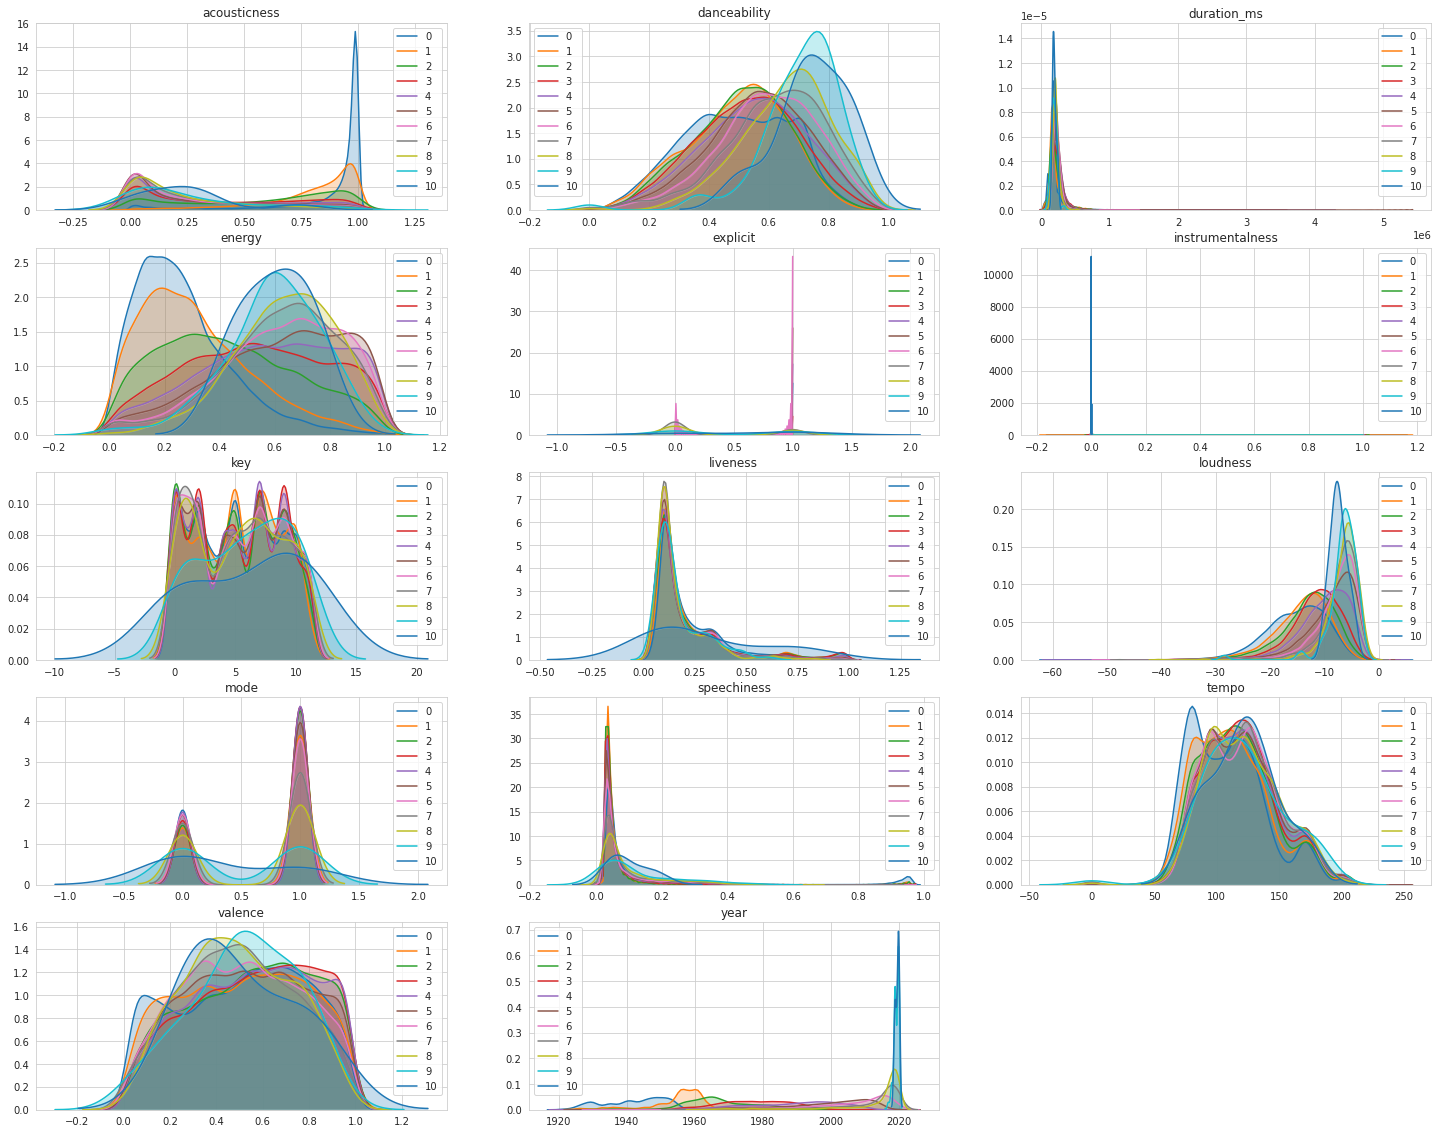

In [ ]:
plt.figure(figsize=(25,20))
for i,col in enumerate(cols):
    plt.subplot(5,3,i+1)
    #sns.kdeplot(train[col])
    gr = data.groupby('popularity')[col]
    for label, arr in gr:
        sns.kdeplot(arr, label=label,shade=True)
    plt.title(col)



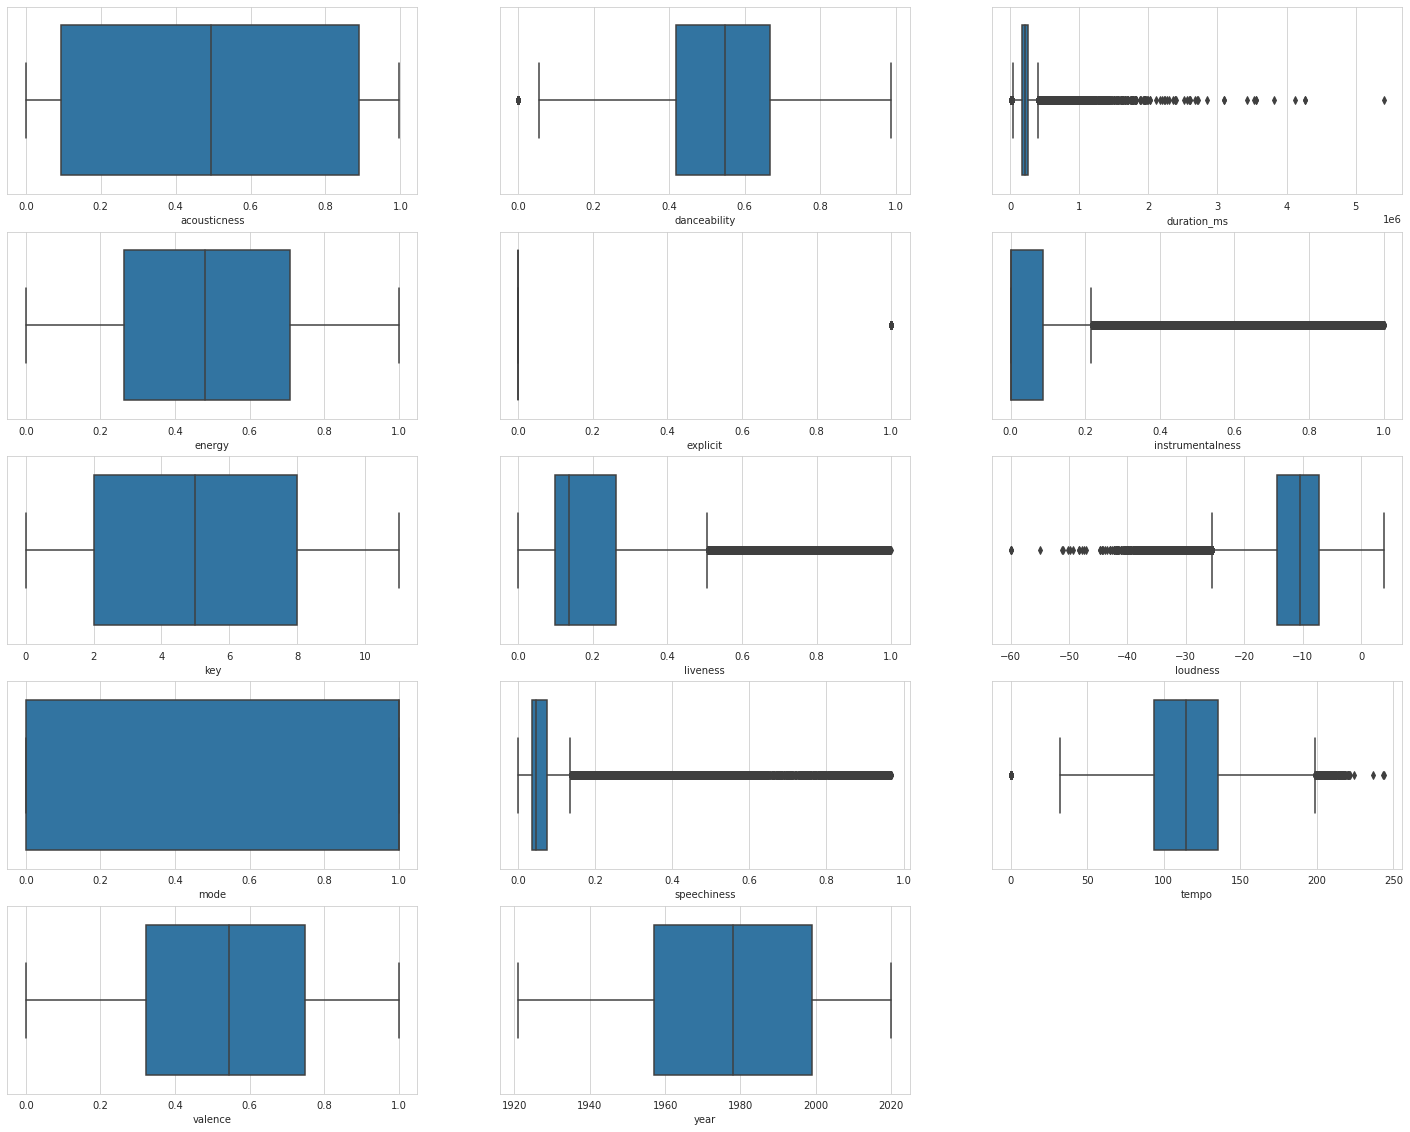

In [ ]:
plt.figure(figsize=(25,20))
for i,col in enumerate(cols):
    plt.subplot(5,3,i+1)
    sns.boxplot(data[col])



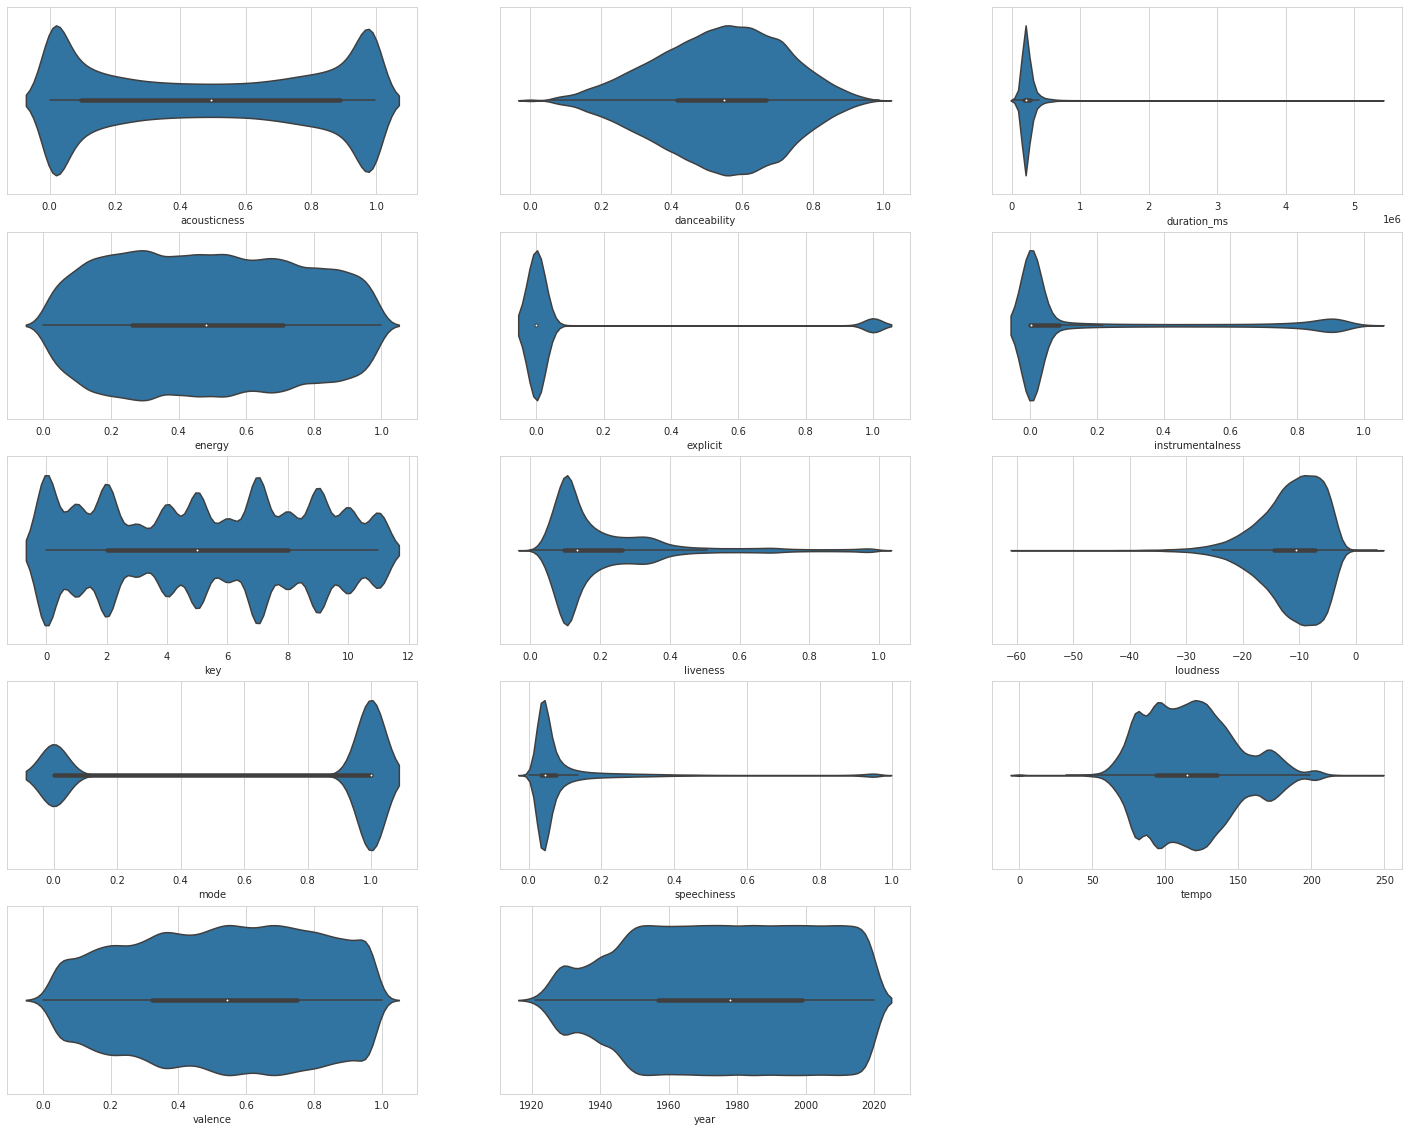

In [ ]:
plt.figure(figsize=(25,20))
for i,col in enumerate(cols):
    plt.subplot(5,3,i+1)
    sns.violinplot(data[col])


In [ ]:
class dataset(Dataset):
  def __init__(self, dataframe = None, target = None):
    self.dataframe = dataframe
    self.train_col = self.dataframe.columns
    self.target = target

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    X = self.dataframe[self.train_col].iloc[idx]
    X = torch.tensor(X).float()

    y = self.target.iloc[idx]
    y = torch.tensor(y).float()

    return X, y

    

In [ ]:
dataset_train = dataset(dataframe=data_X, target = target)

dataset_train

118936

In [ ]:
data_loader = DataLoader(dataset_train, batch_size = 50, shuffle=True)

In [ ]:
class fullConnectNN(nn.Module):
  def __init__(self, num_input):
    super(fullConnectNN,self).__init__()
    
    self.fc1 = nn.Linear(num_input, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 1)
    # self.dropout = nn.Dropout(p=0.3)


  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.sigmoid(self.fc3(x))

    return x

In [ ]:
model = fullConnectNN(num_input=14)
model.to(device)
print(model)

fullConnectNN(
  (fc1): Linear(in_features=14, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [65]:
import torch.optim as optim

# criterion = nn.BCELoss()
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [66]:
for epoch in range(1):  # loop over the dataset multiple times
    print(f'Running epoch {epoch}')
    epoch_loss = 0.0
    batch_loss = 0.0
    batch_no =0
    for data, label in data_loader:
      data, label = data.to(device), label.to(device)

      optimizer.zero_grad()
      
      outputs = model(data)
      # print(outputs)    
      loss = criterion(outputs, label)
      loss.backward()
      
      
      epoch_loss += loss.item()
      batch_loss += loss.item()
      batch_no+=1
      
      if batch_no%50 ==0:
          # print(f'Running epoch {epoch}, batch no {batch_no}')
          print(f'total loss after {batch_no} batches ---- Loss: {batch_loss}')
          optimizer.step()
          
      batch_loss = 0
    print(f'Epoch Loss: {epoch_loss}')
    epoch_loss = 0

Running epoch 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


total loss after 50 batches ---- Loss: 12.131457328796387
total loss after 100 batches ---- Loss: 9.53276538848877
total loss after 150 batches ---- Loss: 8.67245101928711
total loss after 200 batches ---- Loss: 13.145089149475098
total loss after 250 batches ---- Loss: 10.530978202819824
total loss after 300 batches ---- Loss: 10.397757530212402
total loss after 350 batches ---- Loss: 13.349859237670898
total loss after 400 batches ---- Loss: 12.715566635131836
total loss after 450 batches ---- Loss: 10.052833557128906
total loss after 500 batches ---- Loss: 9.216143608093262
total loss after 550 batches ---- Loss: 8.540548324584961
total loss after 600 batches ---- Loss: 9.589529037475586
total loss after 650 batches ---- Loss: 14.975957870483398
total loss after 700 batches ---- Loss: 9.095133781433105
total loss after 750 batches ---- Loss: 8.773026466369629
total loss after 800 batches ---- Loss: 7.092589855194092
total loss after 850 batches ---- Loss: 7.252629280090332
total los

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([36])) that is different to the input size (torch.Size([36, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
total_batch = 0
for i , data in data_loader:
  total_batch+=1
  print(total_batch)